Update on the Voice Model:

For the regression task (predicting total UPDRS), I experimented with various models including multiple neural networks. The best validation R² I achieved was around 0.47, but the test R² dropped to ~0.39, suggesting some overfitting or data imbalance. I believe there's room for improvement in several areas:

- Data processing, particularly stratified splitting and potential outlier handling

- Hyperparameter tuning, especially learning rate schedules and network depth

- Advanced methods, like ensembling or leveraging pretrained models for feature extraction

For the classification task, my best model reached 66% validation accuracy. There's likely headroom here too, I found a published model that achieved 86% accuracy. https://github.com/mrpintime/Parkinsons-Telemonitoring/tree/main

- Same process as above

Further details and specs are documented throughout the notebook

# Voice Processing

## Imports 

In [1]:
!pip install ucimlrepo
!pip install xgboost

import math

import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix

from sklearn.preprocessing import StandardScaler, RobustScaler
from ucimlrepo import fetch_ucirepo
from xgboost import XGBRegressor







[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.8/253.8 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.5/322.5 MB 1.5 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
2025-08-03 00:25:58.008054: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-03 00:25:58.059756: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-03 00:25:58.060536: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-03 00:25:58.061727: E external/local_xla/xl

## xShortcut for all the processing - So after running this block you can go immediately to model development - Not for classifications tho (there's further processing that has to be done)


Feel free to experiment with these since some of the choices were arbitrary

In [2]:
seed = 42
np.random.seed(seed)          
tf.random.set_seed(seed) 
parkinsons_voice = fetch_ucirepo(id=189)
X = parkinsons_voice.data.features
y = parkinsons_voice.data.targets

features_to_drop = [
    'Jitter(%)', 'Jitter:RAP', 'Jitter:DDP',
    'Shimmer(dB)', 'Shimmer:APQ5', 'Shimmer:DDA',
    'Shimmer', 'NHR',   'age',
    'test_time', 'subject#'
] #to address multicollinearity and also to overcome overfitting based on age as id 

X_filtered = X.drop(columns=[col for col in features_to_drop if col in X.columns])

y_target = y["total_UPDRS"]
#y_target = y["motor_UPDRS"]

#this section can definitely be improved to split the data using subject# so that testings willencounter patients that they've never seen
#or any other type of good stratification
X_train, X_temp, y_train, y_temp = train_test_split(
    X_filtered, y_target, test_size=0.5, random_state=seed
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=seed
)

#Necessary for NN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

##  Downloading Data & Other Stuff

In [3]:
seed = 42
np.random.seed(seed)          
tf.random.set_seed(seed) 

In [15]:
parkinsons_voice = fetch_ucirepo(id=189)
X = parkinsons_voice.data.features
y = parkinsons_voice.data.targets

In [5]:
print(parkinsons_voice.metadata)
print(parkinsons_voice.variables)

{'uci_id': 189, 'name': 'Parkinsons Telemonitoring', 'repository_url': 'https://archive.ics.uci.edu/dataset/189/parkinsons+telemonitoring', 'data_url': 'https://archive.ics.uci.edu/static/public/189/data.csv', 'abstract': "Oxford Parkinson's Disease Telemonitoring Dataset", 'area': 'Health and Medicine', 'tasks': ['Regression'], 'characteristics': ['Tabular'], 'num_instances': 5875, 'num_features': 19, 'feature_types': ['Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['motor_UPDRS', 'total_UPDRS'], 'index_col': ['subject#'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5ZS3N', 'creators': ['Athanasios Tsanas', 'Max Little'], 'intro_paper': {'ID': 229, 'type': 'NATIVE', 'title': "Accurate Telemonitoring of Parkinson's Disease Progression by Noninvasive Speech Tests", 'authors': 'A. Tsanas, Max A. Little, P. McSharry, L. Ramig', 'venue': 'IEEE Transactions on Bio

# Data Processing

In [57]:
df = parkinsons_voice.data.features.copy()
df['total_UPDRS'] = parkinsons_voice.data.targets['total_UPDRS']
print(df.shape)       
print(df.columns.tolist())
print(df.head(5))

print(df.info())
print(df.isna().sum())

print(df.describe().T)  

(5875, 20)
['age', 'test_time', 'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP', 'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'Shimmer:APQ11', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE', 'sex', 'total_UPDRS']
   age  test_time  Jitter(%)  Jitter(Abs)  Jitter:RAP  Jitter:PPQ5  \
0   72     5.6431    0.00662     0.000034     0.00401      0.00317   
1   72    12.6660    0.00300     0.000017     0.00132      0.00150   
2   72    19.6810    0.00481     0.000025     0.00205      0.00208   
3   72    25.6470    0.00528     0.000027     0.00191      0.00264   
4   72    33.6420    0.00335     0.000020     0.00093      0.00130   

   Jitter:DDP  Shimmer  Shimmer(dB)  Shimmer:APQ3  Shimmer:APQ5  \
0     0.01204  0.02565        0.230       0.01438       0.01309   
1     0.00395  0.02024        0.179       0.00994       0.01072   
2     0.00616  0.01675        0.181       0.00734       0.00844   
3     0.00573  0.02309        0.327       0.01106       0.01

## Correlation Heat Maps 

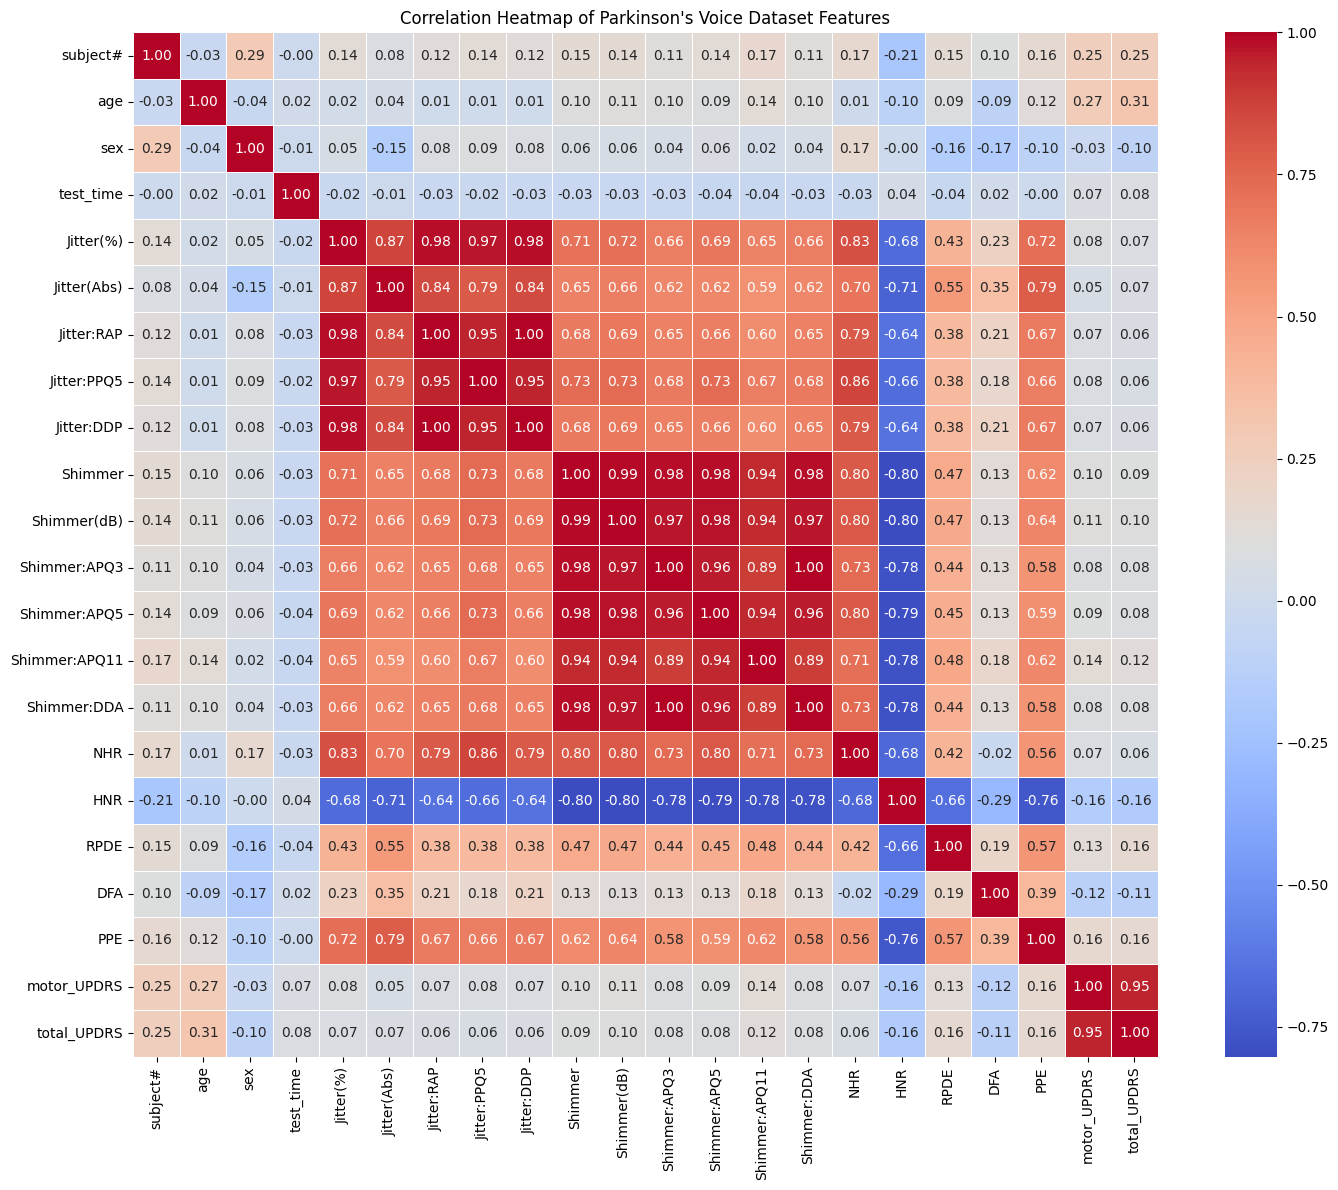

In [7]:
df = parkinsons_voice.data.original.copy()
corr_matrix = df.corr()

plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title("Correlation Heatmap of Parkinson's Voice Dataset Features")
plt.tight_layout()
plt.show()

In [8]:
if 'subject#' in X.columns:
    X = X.drop(columns=['subject#'])
if 'test_time' in X.columns:
    X = X.drop(columns=['test_time'])

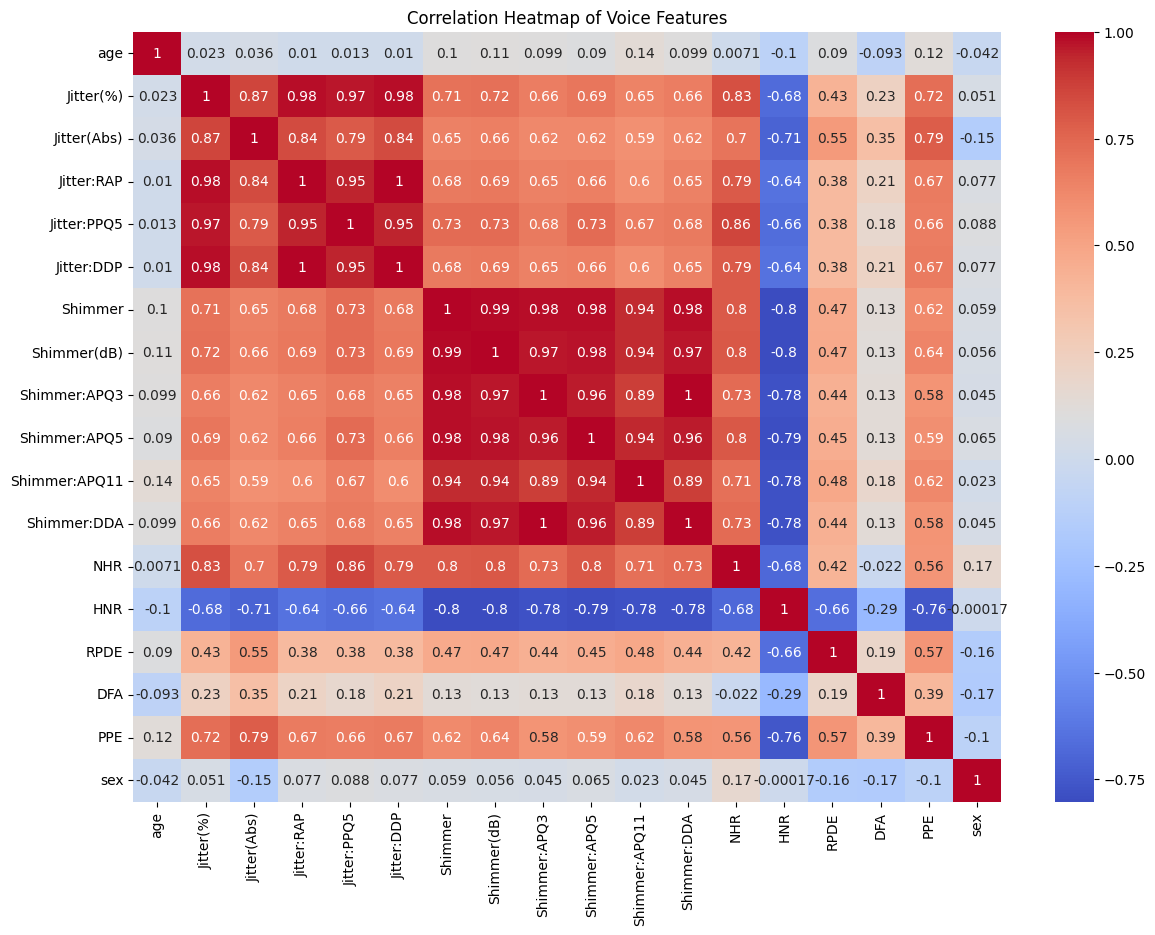

In [9]:
plt.figure(figsize=(14, 10))
sns.heatmap(X.corr(), cmap='coolwarm',annot = True)
plt.title("Correlation Heatmap of Voice Features")
plt.xticks(rotation=90)
plt.show()

In [10]:
'''sns.pairplot(X, corner=True, plot_kws={"s": 10})
plt.suptitle("All Feature vs Feature Pairwise Plots", y=1.02)
plt.show()'''
#Takes too long - No need to run

'sns.pairplot(X, corner=True, plot_kws={"s": 10})\nplt.suptitle("All Feature vs Feature Pairwise Plots", y=1.02)\nplt.show()'

Dropping Columns with over 90% correlation

In [11]:
features_to_drop = [
    'Jitter(%)', 'Jitter:RAP', 'Jitter:DDP',
    'Shimmer(dB)', 'Shimmer:APQ5', 'Shimmer:DDA',
    'Shimmer', 'NHR'  
]
X_filtered = X.drop(columns=[col for col in features_to_drop if col in X.columns])


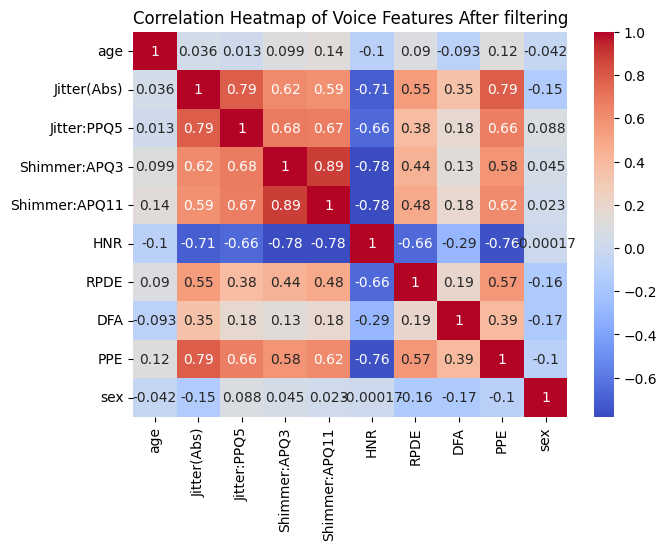

In [12]:
plt.figure(figsize=(7, 5))
sns.heatmap(X_filtered.corr(), cmap='coolwarm', annot = True)
plt.title("Correlation Heatmap of Voice Features After filtering")
plt.xticks(rotation=90)
plt.show()

In [13]:
'''sns.pairplot(X, corner=True, plot_kws={"s": 10})
plt.suptitle("All Feature vs Feature Pairwise Plots", y=1.02)
plt.show()'''

'sns.pairplot(X, corner=True, plot_kws={"s": 10})\nplt.suptitle("All Feature vs Feature Pairwise Plots", y=1.02)\nplt.show()'

## Final Optimized Drop Columns

Drops Age along with other redundant features

In [14]:

'''features_to_drop = [
    'Jitter(%)', 'Jitter:RAP', 'Jitter:DDP',
    'Shimmer(dB)', 'Shimmer:APQ5', 'Shimmer:DDA',
    'Shimmer', 'NHR', 'age'  
]
X_filtered = X.drop(columns=[col for col in features_to_drop if col in X.columns])
'''

"features_to_drop = [\n    'Jitter(%)', 'Jitter:RAP', 'Jitter:DDP',\n    'Shimmer(dB)', 'Shimmer:APQ5', 'Shimmer:DDA',\n    'Shimmer', 'NHR', 'age'  \n]\nX_filtered = X.drop(columns=[col for col in features_to_drop if col in X.columns])\n"

## Target Selection + Data Split

Used Total_UPDRS because it can be applied more universally

POSSIBLE IMPROVEMENT: Data split should probably utilize the patient label so that validation and testing cols can have patients that the model did not see yet

In [15]:
print(df['total_UPDRS'].describe())


count    5875.000000
mean       29.018942
std        10.700283
min         7.000000
25%        21.371000
50%        27.576000
75%        36.399000
max        54.992000
Name: total_UPDRS, dtype: float64


In [16]:
y_target = y["total_UPDRS"]
#y_target = y["motor_UPDRS"]

X_train, X_temp, y_train, y_temp = train_test_split(
    X_filtered, y_target, test_size=0.5, random_state=seed
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=seed
)

# Train & Optimize Random Forest Regression Model

### Baseline Model

In [11]:
model = RandomForestRegressor(n_estimators=100, random_state=seed)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)

rmse = mean_squared_error(y_val, y_pred, squared=False)
r2 = r2_score(y_val, y_pred)
print(f" RMSE: {rmse:.3f}")
print(f" R^2 Score: {r2:.3f}")


 RMSE: 3.215
 R^2 Score: 0.906


### Check for overfitting

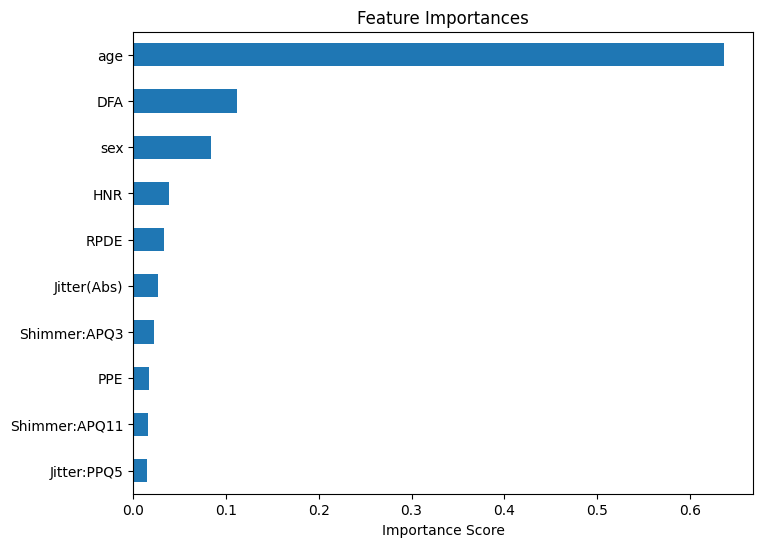

In [16]:
importances = pd.Series(model.feature_importances_, index=X_filtered.columns)
importances.sort_values().plot(kind='barh', figsize=(8, 6))
plt.title("Feature Importances")
plt.xlabel("Importance Score")
plt.show()

In [1]:
print(df['age'].value_counts().sort_index())


NameError: name 'df' is not defined

### Overfitting, so removing Age (as it acts as an id) & Split Data Again

In [52]:
if 'age' in X.columns:
    X_filtered = X_filtered.drop(columns=["age"])

X_train, X_temp, y_train, y_temp = train_test_split(
    X_filtered, y_target, test_size=0.5, random_state=seed
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=seed
)

KeyError: "['age'] not found in axis"

### Check for overfitting again

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

# Train
model = RandomForestRegressor(n_estimators=100, random_state=seed)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_val)

# Metrics
rmse = mean_squared_error(y_val, y_pred, squared=False)
mae  = mean_absolute_error(y_val, y_pred)
r2   = r2_score(y_val, y_pred)
ev   = explained_variance_score(y_val, y_pred)

print(f"RMSE:               {rmse:.3f}")
print(f"MAE:                {mae:.3f}")
print(f"R² Score:           {r2:.3f}")
print(f"Explained Variance: {ev:.3f}")


 RMSE: 8.394
 R^2 Score: 0.358


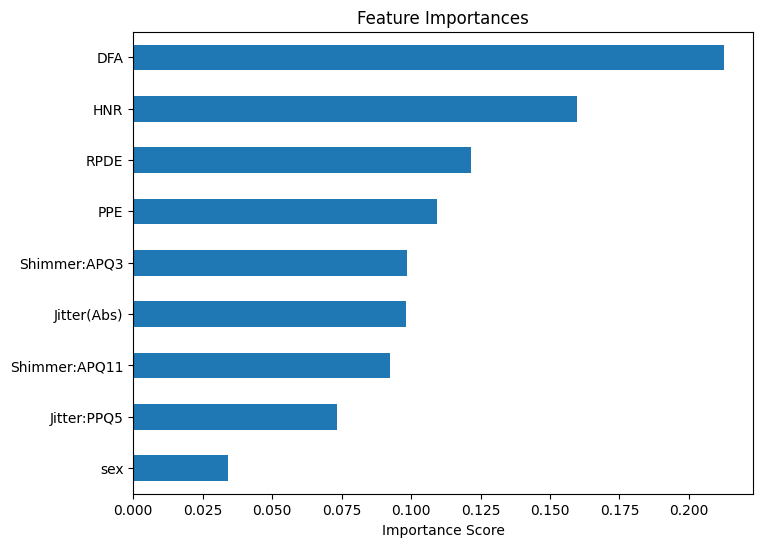

In [19]:
importances = pd.Series(model.feature_importances_, index=X_train.columns)
importances.sort_values().plot(kind='barh', figsize=(8, 6))
plt.title("Feature Importances")
plt.xlabel("Importance Score")
plt.show()

Looks like there are no overfitting and the importance appears to be evenly distributed. Did try dropping sex columns but it lowered the R^2 score

## Hyper-parameter  Optimization

 No need to run the Optimization Blocks Again

### Grid Search

In [20]:
'''param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "max_features": [1.0, "sqrt"]
}

best_r2 = -float("inf")
best_model = None
best_params = None

for params in ParameterGrid(param_grid):
    model = RandomForestRegressor(**params, random_state=42)
    model.fit(X_train, y_train)
    val_pred = model.predict(X_val)
    r2 = r2_score(y_val, val_pred)

    if r2 > best_r2:
        best_r2 = r2
        best_model = model
        best_params = params

print("Best R² on validation set:", best_r2)
print("Best hyperparameters:", best_params)'''


'param_grid = {\n    "n_estimators": [100, 200],\n    "max_depth": [None, 10, 20],\n    "min_samples_split": [2, 5],\n    "min_samples_leaf": [1, 2],\n    "max_features": [1.0, "sqrt"]\n}\n\nbest_r2 = -float("inf")\nbest_model = None\nbest_params = None\n\nfor params in ParameterGrid(param_grid):\n    model = RandomForestRegressor(**params, random_state=42)\n    model.fit(X_train, y_train)\n    val_pred = model.predict(X_val)\n    r2 = r2_score(y_val, val_pred)\n\n    if r2 > best_r2:\n        best_r2 = r2\n        best_model = model\n        best_params = params\n\nprint("Best R² on validation set:", best_r2)\nprint("Best hyperparameters:", best_params)'

In [21]:
'''param_grid = {
    "n_estimators": [200, 400, 600,800,1000],
    "max_depth": [None],
    "min_samples_split": [2],
    "min_samples_leaf": [2],
}

best_r2 = -float("inf")
best_model = None
best_params = None

for params in ParameterGrid(param_grid):
    model = RandomForestRegressor(**params, random_state=42)
    model.fit(X_train, y_train)
    val_pred = model.predict(X_val)
    r2 = r2_score(y_val, val_pred)

    if r2 > best_r2:
        best_r2 = r2
        best_model = model
        best_params = params

print("Best R² on validation set:", best_r2)
print("Best hyperparameters:", best_params)
'''

'param_grid = {\n    "n_estimators": [200, 400, 600,800,1000],\n    "max_depth": [None],\n    "min_samples_split": [2],\n    "min_samples_leaf": [2],\n}\n\nbest_r2 = -float("inf")\nbest_model = None\nbest_params = None\n\nfor params in ParameterGrid(param_grid):\n    model = RandomForestRegressor(**params, random_state=42)\n    model.fit(X_train, y_train)\n    val_pred = model.predict(X_val)\n    r2 = r2_score(y_val, val_pred)\n\n    if r2 > best_r2:\n        best_r2 = r2\n        best_model = model\n        best_params = params\n\nprint("Best R² on validation set:", best_r2)\nprint("Best hyperparameters:", best_params)\n'

In [22]:
'''param_grid = {
    "n_estimators": [1000, 1500, 2000, 2500],
    "max_depth": [None],
    "min_samples_split": [2],
    "min_samples_leaf": [2],
}

best_r2 = -float("inf")
best_model = None
best_params = None

for params in ParameterGrid(param_grid):
    model = RandomForestRegressor(**params, random_state=42)
    model.fit(X_train, y_train)
    val_pred = model.predict(X_val)
    r2 = r2_score(y_val, val_pred)

    if r2 > best_r2:
        best_r2 = r2
        best_model = model
        best_params = params

print("Best R² on validation set:", best_r2)
print("Best hyperparameters:", best_params)'''


'param_grid = {\n    "n_estimators": [1000, 1500, 2000, 2500],\n    "max_depth": [None],\n    "min_samples_split": [2],\n    "min_samples_leaf": [2],\n}\n\nbest_r2 = -float("inf")\nbest_model = None\nbest_params = None\n\nfor params in ParameterGrid(param_grid):\n    model = RandomForestRegressor(**params, random_state=42)\n    model.fit(X_train, y_train)\n    val_pred = model.predict(X_val)\n    r2 = r2_score(y_val, val_pred)\n\n    if r2 > best_r2:\n        best_r2 = r2\n        best_model = model\n        best_params = params\n\nprint("Best R² on validation set:", best_r2)\nprint("Best hyperparameters:", best_params)'

In [23]:
'''param_grid = {
    "n_estimators": [1250, 1500, 1750],
    "max_depth": [None],
    "min_samples_split": [2],
    "min_samples_leaf": [2],
}

best_r2 = -float("inf")
best_model = None
best_params = None

for params in ParameterGrid(param_grid):
    model = RandomForestRegressor(**params, random_state=42)
    model.fit(X_train, y_train)
    val_pred = model.predict(X_val)
    r2 = r2_score(y_val, val_pred)

    if r2 > best_r2:
        best_r2 = r2
        best_model = model
        best_params = params

print("Best R² on validation set:", best_r2)
print("Best hyperparameters:", best_params)'''


'param_grid = {\n    "n_estimators": [1250, 1500, 1750],\n    "max_depth": [None],\n    "min_samples_split": [2],\n    "min_samples_leaf": [2],\n}\n\nbest_r2 = -float("inf")\nbest_model = None\nbest_params = None\n\nfor params in ParameterGrid(param_grid):\n    model = RandomForestRegressor(**params, random_state=42)\n    model.fit(X_train, y_train)\n    val_pred = model.predict(X_val)\n    r2 = r2_score(y_val, val_pred)\n\n    if r2 > best_r2:\n        best_r2 = r2\n        best_model = model\n        best_params = params\n\nprint("Best R² on validation set:", best_r2)\nprint("Best hyperparameters:", best_params)'

## Best Random Forest Regression Model

In [60]:
model = RandomForestRegressor(
    n_estimators=1250,
    max_depth=None,
    max_features='sqrt',
    min_samples_leaf=2,
    min_samples_split=2,
    random_state=seed
)

model.fit(X_train, y_train)

y_pred = model.predict(X_val)

rmse = mean_squared_error(y_val, y_pred, squared=False)
r2 = r2_score(y_val, y_pred)

print(f"RMSE: {rmse:.3f}")
print(f"R^2 Score: {r2:.3f}")

RMSE: 8.307
R^2 Score: 0.371


RMSE: 8.53154285953858
MAE: 6.6600981418705585
R² Score: 0.35952284526494127


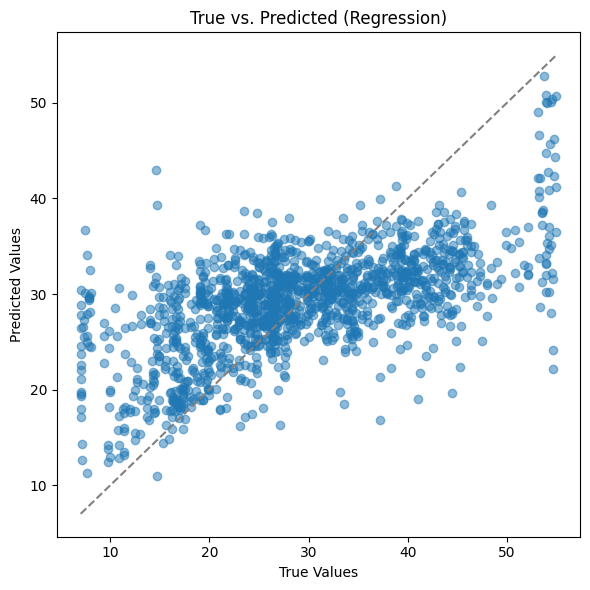

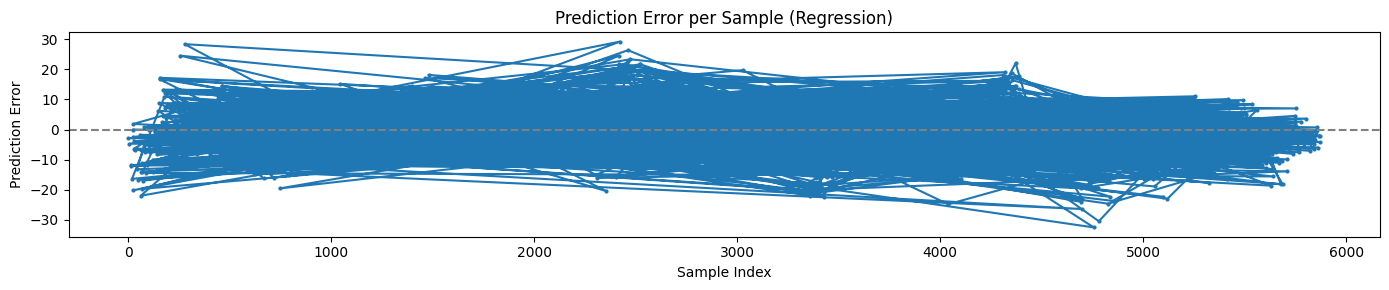

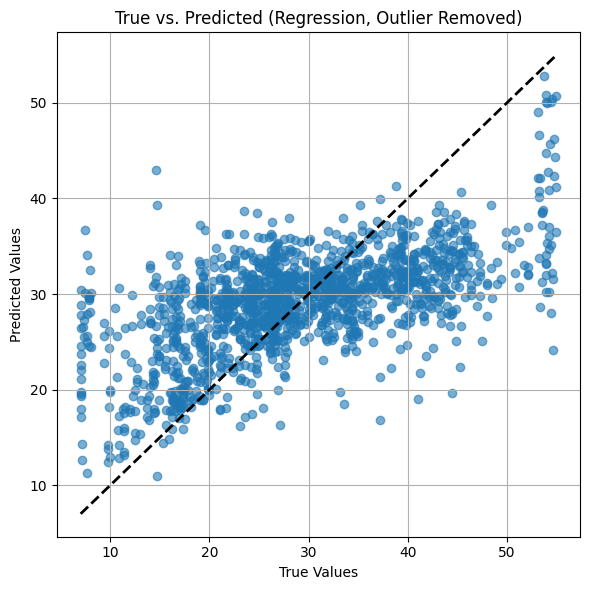

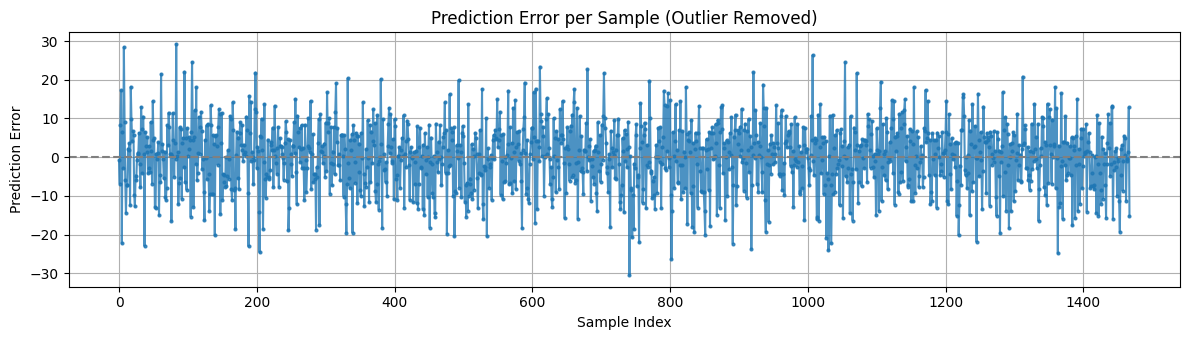

In [15]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Predict (no argmax)
y_test_pred = model.predict(X_test).flatten()

# Evaluation
print("RMSE:", mean_squared_error(y_test, y_test_pred, squared=False))
print("MAE:", mean_absolute_error(y_test, y_test_pred))
print("R² Score:", r2_score(y_test, y_test_pred))

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='gray')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs. Predicted (Regression)")
plt.tight_layout()
plt.show()

errors = y_test_pred - y_test

plt.figure(figsize=(14, 3))
plt.plot(errors, marker='o', linestyle='-', markersize=2)
plt.axhline(0, color='gray', linestyle='--')
plt.title("Prediction Error per Sample (Regression)")
plt.xlabel("Sample Index")
plt.ylabel("Prediction Error")
plt.tight_layout()
plt.show()

# Compute prediction error
errors = y_test_pred - y_test
abs_errors = np.abs(errors)

# Find the index of the largest error
outlier_idx = np.argmax(abs_errors)

# Remove the outlier from predictions and ground truth
y_test_no_outlier = np.delete(y_test, outlier_idx)
y_pred_no_outlier = np.delete(y_test_pred, outlier_idx)
errors_no_outlier = y_pred_no_outlier - y_test_no_outlier

plt.figure(figsize=(6, 6))
plt.scatter(y_test_no_outlier, y_pred_no_outlier, alpha=0.6)
plt.plot([y_test_no_outlier.min(), y_test_no_outlier.max()],
         [y_test_no_outlier.min(), y_test_no_outlier.max()],
         'k--', lw=2)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs. Predicted (Regression, Outlier Removed)")
plt.tight_layout()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 3.5))
plt.plot(errors_no_outlier, linestyle='-', marker='o', markersize=2, alpha=0.8)
plt.axhline(0, color='gray', linestyle='--')
plt.title("Prediction Error per Sample (Outlier Removed)")
plt.xlabel("Sample Index")
plt.ylabel("Prediction Error")
plt.tight_layout()
plt.grid(True)
plt.show()

In [62]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

# Train
model = RandomForestRegressor(n_estimators=100, random_state=seed)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_val)

# Metrics
rmse = mean_squared_error(y_val, y_pred, squared=False)
mae  = mean_absolute_error(y_val, y_pred)
r2   = r2_score(y_val, y_pred)
ev   = explained_variance_score(y_val, y_pred)

print(f"RMSE:               {rmse:.3f}")
print(f"MAE:                {mae:.3f}")
print(f"R² Score:           {r2:.3f}")
print(f"Explained Variance: {ev:.3f}")


RMSE:               8.394
MAE:                6.477
R² Score:           0.358
Explained Variance: 0.358


### Second validation for overfitting

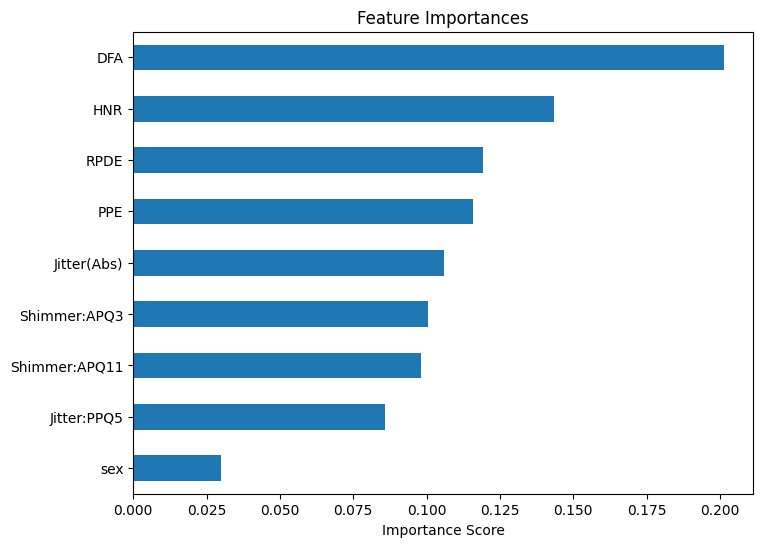

In [25]:
importances = pd.Series(model.feature_importances_, index=X_filtered.columns)
importances.sort_values().plot(kind='barh', figsize=(8, 6))
plt.title("Feature Importances")
plt.xlabel("Importance Score")
plt.show()

### Not overfitting, but the model performance is not that great

# Train Other Model Architectures

In [26]:
# Takes too long so no need to run again
'''models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5),
    "Support Vector Regressor": SVR(kernel='rbf', C=1.0, epsilon=0.2),
    "MLP Regressor": MLPRegressor(hidden_layer_sizes=(64, 64), max_iter=1000, random_state=seed),
    "KNN Regressor": KNeighborsRegressor(n_neighbors=5),
    "Random Forest": RandomForestRegressor(
        n_estimators=1500, max_depth=None, max_features='sqrt',
        min_samples_leaf=2, min_samples_split=2, random_state=seed
    ),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=300, learning_rate=0.1, random_state=seed),
    "XGBoost Regressor": XGBRegressor(n_estimators=300, learning_rate=0.1, random_state=42)
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    r2 = r2_score(y_val, y_pred)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    results.append((name, r2, rmse))

results_df = pd.DataFrame(results, columns=["Model", "Validation R²", "Validation RMSE"])
results_df.sort_values(by="Validation R²", ascending=False, inplace=True)

print(results_df)'''

'models = {\n    "Linear Regression": LinearRegression(),\n    "Ridge Regression": Ridge(alpha=1.0),\n    "Lasso Regression": Lasso(alpha=0.1),\n    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5),\n    "Support Vector Regressor": SVR(kernel=\'rbf\', C=1.0, epsilon=0.2),\n    "MLP Regressor": MLPRegressor(hidden_layer_sizes=(64, 64), max_iter=1000, random_state=seed),\n    "KNN Regressor": KNeighborsRegressor(n_neighbors=5),\n    "Random Forest": RandomForestRegressor(\n        n_estimators=1500, max_depth=None, max_features=\'sqrt\',\n        min_samples_leaf=2, min_samples_split=2, random_state=seed\n    ),\n    "Gradient Boosting": GradientBoostingRegressor(n_estimators=300, learning_rate=0.1, random_state=seed),\n    "XGBoost Regressor": XGBRegressor(n_estimators=300, learning_rate=0.1, random_state=42)\n}\n\nresults = []\nfor name, model in models.items():\n    model.fit(X_train, y_train)\n    y_pred = model.predict(X_val)\n    r2 = r2_score(y_val, y_pred)\n    rmse = mean_squar

Random Forest is still the best model

## Train Neural Network

## Process data for NN

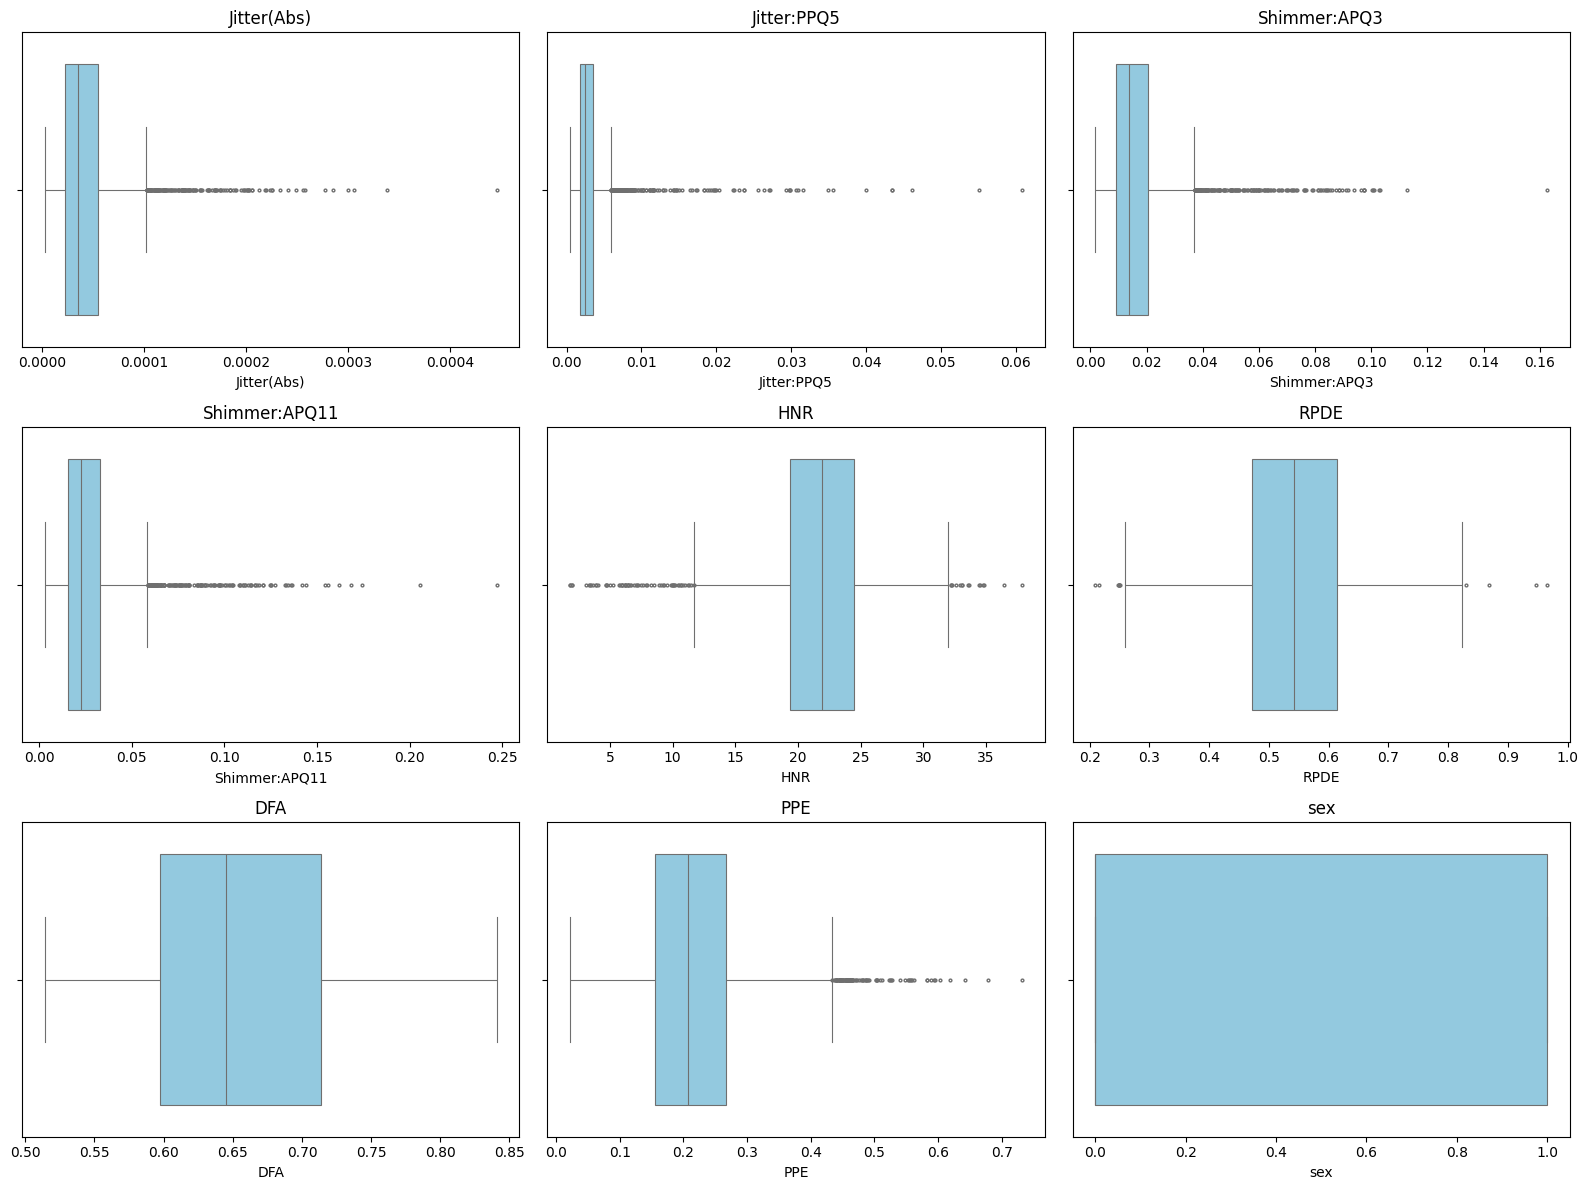

In [27]:
num_features = X_train.shape[1]
num_cols = 3  # Number of plots per row
num_rows = math.ceil(num_features / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 4 * num_rows))
axes = axes.flatten()

for i, col in enumerate(X_train.columns):
    sns.boxplot(x=X_train[col], ax=axes[i], fliersize=2, linewidth=0.8, color="skyblue")
    axes[i].set_title(col)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

### No Extreme Outliers

### Standard Scale

In [3]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

### Robust Scale

In [29]:
'''scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)'''
#Tried and performs worse

'scaler = RobustScaler()\nX_train_scaled = scaler.fit_transform(X_train)\nX_val_scaled = scaler.transform(X_val)'

### Baseline? NN

In [30]:
# Build model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Regression output
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train
model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=32,
    verbose=1
)

# Evaluate
y_pred = model.predict(X_val_scaled).flatten()
rmse = mean_squared_error(y_val, y_pred, squared=False)
r2 = r2_score(y_val, y_pred)

print(f"RMSE: {rmse:.3f}")
print(f"R^2 Score: {r2:.3f}")


Epoch 1/100
92/92 [==============================] - 1s 5ms/step - loss: 458.9861 - val_loss: 522.9216
Epoch 2/100
92/92 [==============================] - 0s 3ms/step - loss: 151.3707 - val_loss: 343.0474
Epoch 3/100
92/92 [==============================] - 0s 3ms/step - loss: 133.2045 - val_loss: 205.1878
Epoch 4/100
92/92 [==============================] - 0s 3ms/step - loss: 140.3216 - val_loss: 136.0538
Epoch 5/100
92/92 [==============================] - 0s 3ms/step - loss: 125.7388 - val_loss: 95.8794
Epoch 6/100
92/92 [==============================] - 0s 2ms/step - loss: 118.8792 - val_loss: 94.8557
Epoch 7/100
92/92 [==============================] - 0s 3ms/step - loss: 124.4692 - val_loss: 80.9595
Epoch 8/100
92/92 [==============================] - 0s 3ms/step - loss: 115.7263 - val_loss: 84.1983
Epoch 9/100
92/92 [==============================] - 0s 3ms/step - loss: 116.0064 - val_loss: 77.0318
Epoch 10/100
92/92 [==============================] - 0s 3ms/step - loss: 114.

## Neural Network Optimization

In [31]:
model = Sequential([
    Dense(256, input_shape=(X_train_scaled.shape[1],)),
    LeakyReLU(),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128),
    LeakyReLU(),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64),
    LeakyReLU(),
    Dropout(0.2),

    Dense(1)  # Regression output
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=45, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=30, verbose=1)

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=300,
    batch_size=32,
    callbacks=[early_stop, checkpoint, reduce_lr],
    verbose=1
)

y_pred = model.predict(X_val_scaled).flatten()
rmse = mean_squared_error(y_val, y_pred, squared=False)
r2 = r2_score(y_val, y_pred)

print(f"RMSE: {rmse:.3f}")
print(f"R^2 Score: {r2:.3f}")


Epoch 1/300
92/92 [==============================] - 2s 10ms/step - loss: 530.3774 - mae: 19.7700 - val_loss: 461.9943 - val_mae: 18.9398 - lr: 0.0010
Epoch 2/300
92/92 [==============================] - 1s 10ms/step - loss: 175.3035 - mae: 10.4858 - val_loss: 199.6366 - val_mae: 11.3594 - lr: 0.0010
Epoch 3/300
92/92 [==============================] - 1s 8ms/step - loss: 140.5132 - mae: 9.5113 - val_loss: 124.2510 - val_mae: 8.7054 - lr: 0.0010
Epoch 4/300
92/92 [==============================] - 1s 9ms/step - loss: 140.7338 - mae: 9.4814 - val_loss: 99.9614 - val_mae: 7.8797 - lr: 0.0010
Epoch 5/300
92/92 [==============================] - 1s 7ms/step - loss: 132.7072 - mae: 9.2162 - val_loss: 84.1910 - val_mae: 7.3865 - lr: 0.0010
Epoch 6/300
92/92 [==============================] - 1s 8ms/step - loss: 128.8177 - mae: 9.1021 - val_loss: 82.6977 - val_mae: 7.2462 - lr: 0.0010
Epoch 7/300
92/92 [==============================] - 1s 8ms/step - loss: 121.9469 - mae: 8.8494 - val_loss: 8

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

model = Sequential([
    Dense(128, input_shape=(X_train_scaled.shape[1],)),
    LeakyReLU(),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128),
    LeakyReLU(),
    Dropout(0.3),

    Dense(64),
    LeakyReLU(),
    Dropout(0.2),

    Dense(32),
    LeakyReLU(),
    Dropout(0.2),
    Dense(1)  # Regression output
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=30, verbose=1),
    EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
]

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=300,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

y_pred = model.predict(X_val_scaled).flatten()
rmse = mean_squared_error(y_val, y_pred, squared=False)
r2 = r2_score(y_val, y_pred)

print(f"RMSE: {rmse:.3f}")
print(f"R^2 Score: {r2:.3f}")

Epoch 1/300
92/92 [==============================] - 2s 7ms/step - loss: 384.1128 - mae: 15.7390 - val_loss: 467.0279 - val_mae: 19.1650 - lr: 0.0010
Epoch 2/300
92/92 [==============================] - 0s 3ms/step - loss: 160.1084 - mae: 10.0367 - val_loss: 304.6672 - val_mae: 14.8385 - lr: 0.0010
Epoch 3/300
92/92 [==============================] - 0s 3ms/step - loss: 143.0413 - mae: 9.4051 - val_loss: 186.9587 - val_mae: 10.9774 - lr: 0.0010
Epoch 4/300
92/92 [==============================] - 0s 3ms/step - loss: 140.6411 - mae: 9.4630 - val_loss: 135.1771 - val_mae: 9.1494 - lr: 0.0010
Epoch 5/300
92/92 [==============================] - 0s 3ms/step - loss: 141.4737 - mae: 9.3943 - val_loss: 101.0348 - val_mae: 7.9873 - lr: 0.0010
Epoch 6/300
92/92 [==============================] - 0s 3ms/step - loss: 132.2740 - mae: 9.1397 - val_loss: 89.9310 - val_mae: 7.5065 - lr: 0.0010
Epoch 7/300
92/92 [==============================] - 0s 3ms/step - loss: 124.7969 - mae: 8.9492 - val_loss: 

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='sigmoid'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Regression output
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=30, verbose=1),
    EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
]

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=300,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

y_pred = model.predict(X_val_scaled).flatten()
rmse = mean_squared_error(y_val, y_pred, squared=False)
r2 = r2_score(y_val, y_pred)

print(f"RMSE: {rmse:.3f}")
print(f"R^2 Score: {r2:.3f}")

Epoch 1/300
92/92 [==============================] - 2s 5ms/step - loss: 375.7271 - mae: 15.7430 - val_loss: 609.1146 - val_mae: 22.4393 - lr: 0.0010
Epoch 2/300
92/92 [==============================] - 0s 3ms/step - loss: 146.0475 - mae: 9.6307 - val_loss: 432.0366 - val_mae: 18.3520 - lr: 0.0010
Epoch 3/300
92/92 [==============================] - 0s 3ms/step - loss: 136.1338 - mae: 9.2368 - val_loss: 234.1007 - val_mae: 12.5762 - lr: 0.0010
Epoch 4/300
92/92 [==============================] - 0s 3ms/step - loss: 130.1717 - mae: 9.0484 - val_loss: 128.0299 - val_mae: 8.8867 - lr: 0.0010
Epoch 5/300
92/92 [==============================] - 0s 3ms/step - loss: 123.6506 - mae: 8.8375 - val_loss: 84.2566 - val_mae: 7.1754 - lr: 0.0010
Epoch 6/300
92/92 [==============================] - 0s 3ms/step - loss: 114.3619 - mae: 8.4398 - val_loss: 80.4205 - val_mae: 7.0383 - lr: 0.0010
Epoch 7/300
92/92 [==============================] - 0s 3ms/step - loss: 110.5712 - mae: 8.2907 - val_loss: 73

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

model = Sequential([
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='sigmoid'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Regression output
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, verbose=1),
    EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
]

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=300,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

y_pred = model.predict(X_val_scaled).flatten()
rmse = mean_squared_error(y_val, y_pred, squared=False)
r2 = r2_score(y_val, y_pred)

print(f"RMSE: {rmse:.3f}")
print(f"R^2 Score: {r2:.3f}")

Epoch 1/300
92/92 [==============================] - 2s 7ms/step - loss: 466.2141 - mae: 17.9260 - val_loss: 486.7916 - val_mae: 19.6911 - lr: 0.0010
Epoch 2/300
92/92 [==============================] - 0s 4ms/step - loss: 154.5234 - mae: 9.8692 - val_loss: 275.0973 - val_mae: 13.9610 - lr: 0.0010
Epoch 3/300
92/92 [==============================] - 0s 4ms/step - loss: 138.4125 - mae: 9.3466 - val_loss: 133.2607 - val_mae: 9.1931 - lr: 0.0010
Epoch 4/300
92/92 [==============================] - 0s 4ms/step - loss: 134.0977 - mae: 9.1606 - val_loss: 95.1738 - val_mae: 7.6711 - lr: 0.0010
Epoch 5/300
92/92 [==============================] - 0s 3ms/step - loss: 122.9230 - mae: 8.8087 - val_loss: 79.5237 - val_mae: 7.0003 - lr: 0.0010
Epoch 6/300
92/92 [==============================] - 0s 4ms/step - loss: 117.2660 - mae: 8.5729 - val_loss: 76.1551 - val_mae: 6.8563 - lr: 0.0010
Epoch 7/300
92/92 [==============================] - 0s 4ms/step - loss: 118.3391 - mae: 8.6315 - val_loss: 77.8

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Regression output
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=30, verbose=1),
    EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
]

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=300,
    batch_size=10,
    callbacks=callbacks,
    verbose=1
)

y_pred = model.predict(X_val_scaled).flatten()
rmse = mean_squared_error(y_val, y_pred, squared=False)
r2 = r2_score(y_val, y_pred)

print(f"RMSE: {rmse:.3f}")
print(f"R^2 Score: {r2:.3f}")

Epoch 1/300
294/294 [==============================] - 2s 5ms/step - loss: 228.4837 - mae: 11.8314 - val_loss: 233.2654 - val_mae: 12.5094 - lr: 0.0010
Epoch 2/300
294/294 [==============================] - 1s 3ms/step - loss: 147.0714 - mae: 9.5899 - val_loss: 98.9638 - val_mae: 7.8211 - lr: 0.0010
Epoch 3/300
294/294 [==============================] - 1s 3ms/step - loss: 129.6915 - mae: 9.0638 - val_loss: 93.5051 - val_mae: 7.6255 - lr: 0.0010
Epoch 4/300
294/294 [==============================] - 1s 3ms/step - loss: 127.7317 - mae: 8.8916 - val_loss: 86.2433 - val_mae: 7.3508 - lr: 0.0010
Epoch 5/300
294/294 [==============================] - 1s 3ms/step - loss: 121.9761 - mae: 8.7968 - val_loss: 80.1916 - val_mae: 7.1189 - lr: 0.0010
Epoch 6/300
294/294 [==============================] - 1s 3ms/step - loss: 117.4542 - mae: 8.5670 - val_loss: 79.4481 - val_mae: 7.0958 - lr: 0.0010
Epoch 7/300
294/294 [==============================] - 1s 3ms/step - loss: 117.4068 - mae: 8.5114 - val

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Regression output
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=30, verbose=1),
    EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
]

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=300,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

y_pred = model.predict(X_val_scaled).flatten()
rmse = mean_squared_error(y_val, y_pred, squared=False)
r2 = r2_score(y_val, y_pred)

print(f"RMSE: {rmse:.3f}")
print(f"R^2 Score: {r2:.3f}")

Epoch 1/300
92/92 [==============================] - 2s 6ms/step - loss: 397.1013 - mae: 16.0452 - val_loss: 562.2929 - val_mae: 21.4278 - lr: 0.0010
Epoch 2/300
92/92 [==============================] - 0s 4ms/step - loss: 142.4626 - mae: 9.5119 - val_loss: 397.9624 - val_mae: 17.5868 - lr: 0.0010
Epoch 3/300
92/92 [==============================] - 0s 4ms/step - loss: 125.6553 - mae: 8.9057 - val_loss: 236.6893 - val_mae: 12.8360 - lr: 0.0010
Epoch 4/300
92/92 [==============================] - 0s 4ms/step - loss: 127.0565 - mae: 8.9111 - val_loss: 157.0170 - val_mae: 10.0778 - lr: 0.0010
Epoch 5/300
92/92 [==============================] - 0s 3ms/step - loss: 126.8338 - mae: 8.8161 - val_loss: 108.7742 - val_mae: 8.2267 - lr: 0.0010
Epoch 6/300
92/92 [==============================] - 0s 4ms/step - loss: 117.9635 - mae: 8.5812 - val_loss: 95.9345 - val_mae: 7.7709 - lr: 0.0010
Epoch 7/300
92/92 [==============================] - 0s 3ms/step - loss: 115.2151 - mae: 8.5498 - val_loss: 

Key Findings - not like 100% tho since there are a lot more combination of everything

128 - 128 -64-32 works the best 

Best activation function: relu

Batch size:16

But theres probably a lot of ways to optimize this further

## Best Model So Far

In [68]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Regression output
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=30, verbose=1),
    EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
]

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=300,
    batch_size=16,
    callbacks=callbacks,
    verbose=1
)

y_pred = model.predict(X_val_scaled).flatten()
rmse = mean_squared_error(y_val, y_pred, squared=False)
r2 = r2_score(y_val, y_pred)

print(f"RMSE: {rmse:.3f}")
print(f"R^2 Score: {r2:.3f}")

Epoch 1/300
184/184 [==============================] - 3s 6ms/step - loss: 277.2464 - mae: 13.1391 - val_loss: 394.1004 - val_mae: 17.3896 - lr: 0.0010
Epoch 2/300
184/184 [==============================] - 1s 4ms/step - loss: 139.8604 - mae: 9.4062 - val_loss: 177.1799 - val_mae: 10.7350 - lr: 0.0010
Epoch 3/300
184/184 [==============================] - 1s 4ms/step - loss: 126.8023 - mae: 8.9479 - val_loss: 90.8483 - val_mae: 7.4885 - lr: 0.0010
Epoch 4/300
184/184 [==============================] - 1s 4ms/step - loss: 116.1606 - mae: 8.5220 - val_loss: 87.3694 - val_mae: 7.3734 - lr: 0.0010
Epoch 5/300
184/184 [==============================] - 1s 4ms/step - loss: 112.5897 - mae: 8.3828 - val_loss: 77.0939 - val_mae: 6.9103 - lr: 0.0010
Epoch 6/300
184/184 [==============================] - 1s 4ms/step - loss: 112.2560 - mae: 8.3869 - val_loss: 74.7397 - val_mae: 6.8723 - lr: 0.0010
Epoch 7/300
184/184 [==============================] - 1s 4ms/step - loss: 106.4367 - mae: 8.1189 - v

In [69]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

# After your existing fit and predict:
y_pred = model.predict(X_val_scaled).flatten()

# Compute metrics
rmse = mean_squared_error(y_val, y_pred, squared=False)
mae  = mean_absolute_error(y_val, y_pred)
r2   = r2_score(y_val, y_pred)
ev   = explained_variance_score(y_val, y_pred)

print(f"RMSE:               {rmse:.3f}")
print(f"MAE:                {mae:.3f}")
print(f"R² Score:           {r2:.3f}")
print(f"Explained Variance: {ev:.3f}")


46/46 [==============================] - 0s 2ms/step
RMSE:               7.677
MAE:                5.836
R² Score:           0.463
Explained Variance: 0.466


46/46 [==============================] - 0s 1ms/step
RMSE: 8.213510985950949
MAE: 6.076341098191772
R² Score: 0.4063832122969444


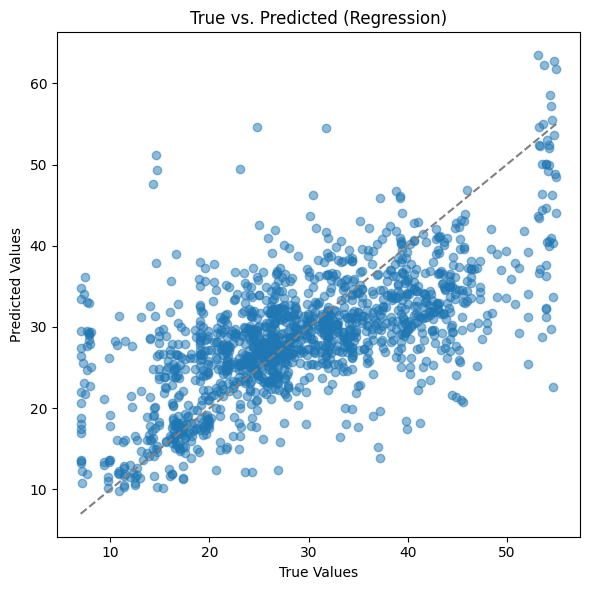

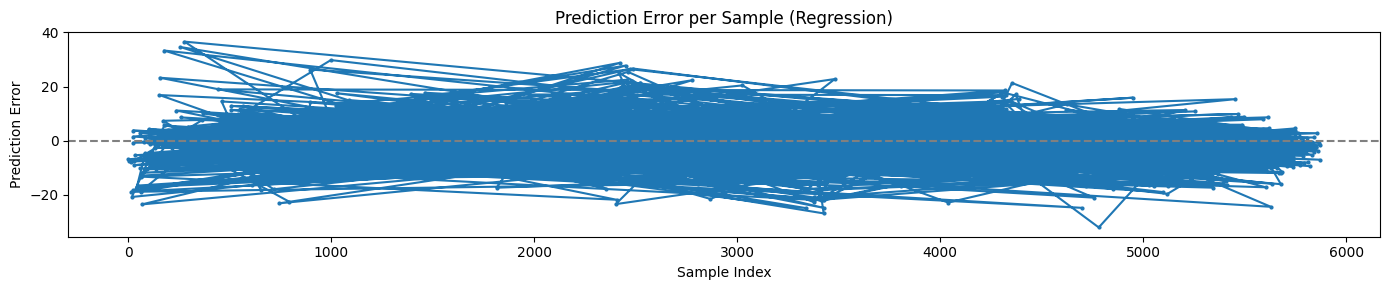

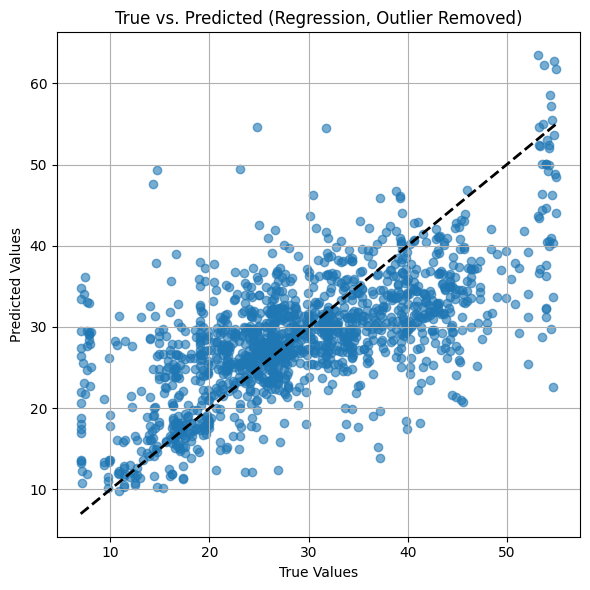

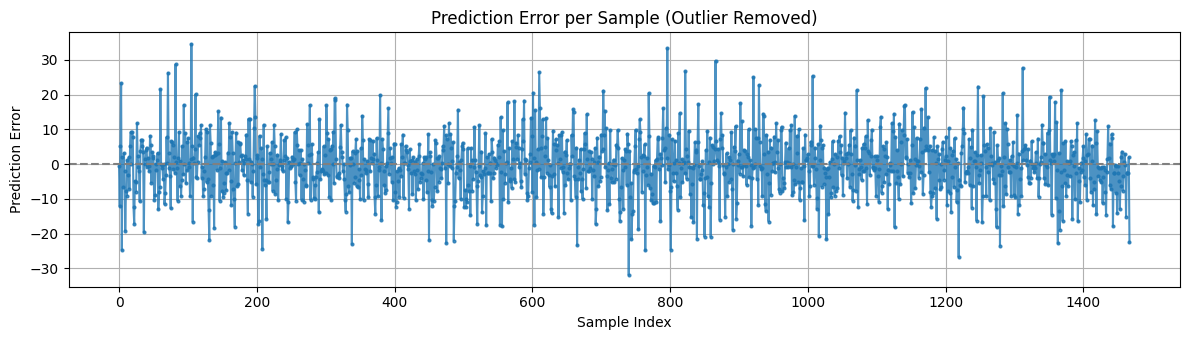

In [49]:
X_test_scaled = scaler.transform(X_test)

y_test_pred = model.predict(X_test_scaled).argmax(axis=1)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Predict (no argmax)
y_test_pred = model.predict(X_test_scaled).flatten()

# Evaluation
print("RMSE:", mean_squared_error(y_test, y_test_pred, squared=False))
print("MAE:", mean_absolute_error(y_test, y_test_pred))
print("R² Score:", r2_score(y_test, y_test_pred))

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='gray')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs. Predicted (Regression)")
plt.tight_layout()
plt.show()

errors = y_test_pred - y_test

plt.figure(figsize=(14, 3))
plt.plot(errors, marker='o', linestyle='-', markersize=2)
plt.axhline(0, color='gray', linestyle='--')
plt.title("Prediction Error per Sample (Regression)")
plt.xlabel("Sample Index")
plt.ylabel("Prediction Error")
plt.tight_layout()
plt.show()

# Compute prediction error
errors = y_test_pred - y_test
abs_errors = np.abs(errors)

# Find the index of the largest error
outlier_idx = np.argmax(abs_errors)

# Remove the outlier from predictions and ground truth
y_test_no_outlier = np.delete(y_test, outlier_idx)
y_pred_no_outlier = np.delete(y_test_pred, outlier_idx)
errors_no_outlier = y_pred_no_outlier - y_test_no_outlier

plt.figure(figsize=(6, 6))
plt.scatter(y_test_no_outlier, y_pred_no_outlier, alpha=0.6)
plt.plot([y_test_no_outlier.min(), y_test_no_outlier.max()],
         [y_test_no_outlier.min(), y_test_no_outlier.max()],
         'k--', lw=2)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs. Predicted (Regression, Outlier Removed)")
plt.tight_layout()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 3.5))
plt.plot(errors_no_outlier, linestyle='-', marker='o', markersize=2, alpha=0.8)
plt.axhline(0, color='gray', linestyle='--')
plt.title("Prediction Error per Sample (Outlier Removed)")
plt.xlabel("Sample Index")
plt.ylabel("Prediction Error")
plt.tight_layout()
plt.grid(True)
plt.show()



Ok so its still 0.388.... maybe there are just too much noice in the voice data

## Ensemble + age (stratified)

In [24]:
seed = 42
np.random.seed(seed)          
tf.random.set_seed(seed) 
parkinsons_voice = fetch_ucirepo(id=189)


age = parkinsons_voice.data.features['age']
X  = parkinsons_voice.data.features.copy()
bins = [age.min() - 1, 40, 50, 60, 70, age.max()]
labels = ['<40', '40–50', '50–60', '60–70', '70+']
age_cat = pd.cut(age, bins=bins, labels=labels)
features_to_drop = [
    'Jitter(%)', 'Jitter:RAP', 'Jitter:DDP',
    'Shimmer(dB)', 'Shimmer:APQ5', 'Shimmer:DDA',
    'Shimmer', 'NHR',
    'test_time', 'subject#'
]

X = X.drop(columns=[col for col in features_to_drop if col in X.columns])
y = parkinsons_voice.data.targets['total_UPDRS']

X_train, X_temp, y_train, y_temp, age_train, age_temp = train_test_split(
    X, y, age_cat,
    test_size=0.5,         # leaves 50% for temp
    random_state=42,
    stratify=age_cat
)

# 4. Second split: split the temp half into val & test equally
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,         # splits temp into 25% each
    random_state=42,
    stratify=age_temp
)

print("Train age-bin distrib:\n", age_train.value_counts(normalize=True))
print("Val   age-bin distrib:\n", age_temp.loc[X_val.index].value_counts(normalize=True))
print("Test  age-bin distrib:\n", age_temp.loc[X_test.index].value_counts(normalize=True))


Train age-bin distrib:
 age
60–70    0.335376
70+      0.318352
50–60    0.285325
40–50    0.043582
<40      0.017365
Name: proportion, dtype: float64
Val   age-bin distrib:
 age
60–70    0.335602
70+      0.318584
50–60    0.285228
40–50    0.043567
<40      0.017018
Name: proportion, dtype: float64
Test  age-bin distrib:
 age
60–70    0.335602
70+      0.318584
50–60    0.285228
40–50    0.043567
<40      0.017018
Name: proportion, dtype: float64


In [27]:
#Build a DataFrame with age & target (or whatever y)
df = parkinsons_voice.data.features.copy()
df['target'] = parkinsons_voice.data.targets['total_UPDRS']

#Compute count per age
age_counts = df['age'].value_counts().sort_values(ascending=False)
# This gives a Series: index=age, value=#samples

#Define your target sizes (50%,25%,25%)
total = len(df)
targets = {
    'train': total * 0.7,
    'val':   total * 0.15,
    'test':  total * 0.15,
}

#  keep track of current sum per split; sort ages by descending count
current = {k: 0 for k in targets}
assignment = {}  # age -> split

for age, count in age_counts.items():
    # compute “fill ratio” = current[split] / targets[split]
    ratios = {s: current[s] / targets[s] for s in targets}
    # pick the split with the smallest ratio (i.e. farthest below its target)
    best_split = min(ratios, key=ratios.get)
    assignment[age] = best_split
    current[best_split] += count

#filter df into X/y for each split
splits = {s: {'X': [], 'y': []} for s in targets}
for split in splits:
    ages_in_split = [age for age, s in assignment.items() if s == split]
    mask = df['age'].isin(ages_in_split)
    splits[split]['X'] = df.loc[mask].drop(columns=['age','target'])
    splits[split]['y'] = df.loc[mask,  'target']

for split in ['train','val','test']:
    print(f"{split.upper():5} | n_samples = {len(splits[split]['X']):4} | "
          f"pct = {100*len(splits[split]['X'])/total:5.1f}%")

for name, split_df in [('Train', splits['train']['X']),
                       ('Val',   splits['val']['X']),
                       ('Test',  splits['test']['X'])]:
    freqs = split_df.copy()
    freqs['age'] = df.loc[split_df.index, 'age']
    print(f"\n{name} age distribution:")
    print(freqs['age'].value_counts(normalize=True).sort_index())

ages = df['age']

Q1, Q3 = np.percentile(ages, [25,75])
IQR = Q3 - Q1
lower_bound = Q1 - 1.5*IQR
print("Lower outlier cutoff =", lower_bound)

TRAIN | n_samples = 4055 | pct =  69.0%
VAL   | n_samples =  861 | pct =  14.7%
TEST  | n_samples =  959 | pct =  16.3%

Train age distribution:
age
49    0.063132
55    0.065845
56    0.034525
57    0.094945
58    0.105795
59    0.073736
60    0.038471
61    0.036991
62    0.058200
68    0.078175
72    0.076449
73    0.094945
74    0.066831
76    0.035512
78    0.041430
85    0.035018
Name: proportion, dtype: float64

Val age distribution:
age
63    0.181185
66    0.490128
67    0.328688
Name: proportion, dtype: float64

Test age distribution:
age
36    0.105318
65    0.424400
71    0.172054
75    0.298227
Name: proportion, dtype: float64
Lower outlier cutoff = 37.0


In [31]:
import numpy as np
import pandas as pd
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import PredefinedSplit, HalvingRandomSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# 1) Glue train+val and build PredefinedSplit
X_tv = pd.concat([splits["train"]["X"], splits["val"]["X"]], axis=0)
y_tv = pd.concat([splits["train"]["y"], splits["val"]["y"]], axis=0)

folds = np.array(
    [-1] * len(splits["train"]["X"]) +
    [ 0] * len(splits["val"]["X"])
)
ps = PredefinedSplit(test_fold=folds)

# 2) Define RF search space (exclude n_estimators)
rf_param_dist = {
    "max_depth":         [None] + list(range(3, 31, 3)),
    "min_samples_split": list(range(2, 21)),
    "min_samples_leaf":  list(range(1, 11)),
    "max_features":      [1.0, "sqrt", "log2"],
}

# 3) HalvingRandomSearchCV over n_estimators
halving_rf = HalvingRandomSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=rf_param_dist,
    resource="n_estimators",   # budget parameter
    min_resources=50,          # start with 50 trees
    max_resources=1500,        # up to 1500 trees
    factor=3,                  # keep top third each round
    cv=ps,
    scoring="neg_mean_squared_error",
    random_state=42,
    n_jobs=1,
    verbose=2
)

# 4) Run the search
halving_rf.fit(X_tv, y_tv)

print("Best RF params (excluding n_estimators):",
      {k: v for k, v in halving_rf.best_params_.items() if k != "n_estimators"})
print("Best n_estimators:", halving_rf.best_params_["n_estimators"])
print("Best CV MSE:", -halving_rf.best_score_)

# 5) Retrain & test
best_rf = halving_rf.best_estimator_
best_rf.set_params(n_estimators=halving_rf.best_params_["n_estimators"])
best_rf.fit(X_tv, y_tv)

X_test, y_test = splits["test"]["X"], splits["test"]["y"]
mse_test = mean_squared_error(y_test, best_rf.predict(X_test))
print("RF Test MSE:", mse_test)


n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 50
max_resources_: 1500
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 30
n_resources: 50
Fitting 1 folds for each of 30 candidates, totalling 30 fits
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=6, min_samples_split=7, n_estimators=50; total time=   0.3s
[CV] END max_depth=27, max_features=sqrt, min_samples_leaf=4, min_samples_split=15, n_estimators=50; total time=   0.6s
[CV] END max_depth=27, max_features=1.0, min_samples_leaf=6, min_samples_split=3, n_estimators=50; total time=   2.0s
[CV] END max_depth=27, max_features=1.0, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   2.1s
[CV] END max_depth=18, max_features=sqrt, min_samples_leaf=9, min_samples_split=12, n_estimators=50; total time=   0.5s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=3, min_samples_split=16, n_estimators=50; total time=   0.5s
[CV] END max_depth=30, max_

In [30]:
import numpy as np
import pandas as pd
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import PredefinedSplit, HalvingRandomSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, RegressorMixin

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

# ─── 0) Load or build your DataFrame `df` with features + `age` + target column ───
# e.g. df = your_dataframe.copy()
#      df['target'] = ...

# ─── 1) Create age‐stratified splits dict ───────────────────────────────────────────
total = len(df)
age_counts = df['age'].value_counts().sort_values(ascending=False)
targets = {'train': total*0.7, 'val': total*0.15, 'test': total*0.15}
current = {k: 0 for k in targets}
assignment = {}

for age, cnt in age_counts.items():
    # pick split that’s furthest below its target proportion
    frac = {s: current[s]/targets[s] for s in targets}
    pick = min(frac, key=frac.get)
    assignment[age] = pick
    current[pick] += cnt

# build the actual X/y splits
splits = {s: {'X': None, 'y': None} for s in targets}
for s in splits:
    ages = [age for age, grp in assignment.items() if grp == s]
    mask = df['age'].isin(ages)
    splits[s]['X'] = df.loc[mask].drop(columns=['age','target'])
    splits[s]['y'] = df.loc[mask, 'target']

# ─── 2) Glue train+val and build PredefinedSplit ──────────────────────────────────
X_tv = pd.concat([splits['train']['X'], splits['val']['X']], axis=0)
y_tv = pd.concat([splits['train']['y'], splits['val']['y']], axis=0)

# -1 for train rows, 0 for val rows
folds = np.array(
    [-1] * len(splits['train']['X']) +
    [ 0] * len(splits['val']['X'])
)
ps = PredefinedSplit(test_fold=folds)

# ─── 3) Define your 3-layer Keras regressor ──────────────────────────────────────
class KerasRegressor3L(BaseEstimator, RegressorMixin):
    def __init__(self,
                 hidden_units_1=64,
                 hidden_units_2=32,
                 hidden_units_3=16,
                 lr=1e-3,
                 epochs=50,
                 batch_size=32,
                 verbose=0):
        self.hidden_units_1 = hidden_units_1
        self.hidden_units_2 = hidden_units_2
        self.hidden_units_3 = hidden_units_3
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.model_ = None

    def build_model(self, input_dim):
        m = Sequential([
            Input(shape=(input_dim,)),
            Dense(self.hidden_units_1, activation='relu'),
            Dense(self.hidden_units_2, activation='relu'),
            Dense(self.hidden_units_3, activation='relu'),
            Dense(1)
        ])
        m.compile(optimizer=Adam(self.lr), loss='mse')
        return m

    def fit(self, X, y):
        X, y = np.asarray(X), np.asarray(y)
        self.model_ = self.build_model(X.shape[1])
        self.model_.fit(X, y,
                        epochs=self.epochs,
                        batch_size=self.batch_size,
                        verbose=self.verbose)
        return self

    def predict(self, X):
        return self.model_.predict(np.asarray(X), verbose=0).ravel()

    def score(self, X, y):
        preds = self.predict(X)
        return -mean_squared_error(np.asarray(y), preds)

# ─── 4) Set up HalvingRandomSearchCV over epochs ─────────────────────────────────
nn_param_dist = {
    "hidden_units_1": [32, 64, 128],
    "hidden_units_2": [16, 32, 64],
    "hidden_units_3": [16, 32, 64],
    "lr":             [1e-4, 1e-3, 1e-2],
    "batch_size":     [16, 32, 64],
}

halving_nn = HalvingRandomSearchCV(
    estimator=KerasRegressor3L(verbose=0),
    param_distributions=nn_param_dist,
    resource="epochs",
    min_resources=20,
    max_resources=200,
    factor=3,
    cv=ps,
    scoring="neg_mean_squared_error",
    random_state=42,
    n_jobs=1,
    verbose=2
)

# ─── 5) Run the hyperparameter search ───────────────────────────────────────────
halving_nn.fit(X_tv, y_tv)

print("Best params (excl. epochs):",
      {k:v for k,v in halving_nn.best_params_.items() if k!="epochs"})
print("Best epochs:", halving_nn.best_params_["epochs"])
print("Best CV MSE:", -halving_nn.best_score_)

# ─── 6) Retrain best model & test ───────────────────────────────────────────────
best_nn = halving_nn.best_estimator_
best_nn.set_params(epochs=halving_nn.best_params_["epochs"])
best_nn.fit(X_tv, y_tv)

X_test, y_test = splits['test']['X'], splits['test']['y']
print("NN Test MSE:", mean_squared_error(y_test, best_nn.predict(X_test)))


n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 20
max_resources_: 200
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 10
n_resources: 20
Fitting 1 folds for each of 10 candidates, totalling 10 fits
[CV] END batch_size=16, epochs=20, hidden_units_1=32, hidden_units_2=64, hidden_units_3=64, lr=0.0001; total time=   6.6s
[CV] END batch_size=16, epochs=20, hidden_units_1=32, hidden_units_2=16, hidden_units_3=64, lr=0.0001; total time=   5.6s
[CV] END batch_size=32, epochs=20, hidden_units_1=128, hidden_units_2=32, hidden_units_3=64, lr=0.01; total time=   3.6s
[CV] END batch_size=64, epochs=20, hidden_units_1=128, hidden_units_2=32, hidden_units_3=64, lr=0.001; total time=   2.1s
[CV] END batch_size=64, epochs=20, hidden_units_1=128, hidden_units_2=64, hidden_units_3=32, lr=0.001; total time=   2.1s
[CV] END batch_size=64, epochs=20, hidden_units_1=32, hidden_units_2=32, hidden_units_3=32, lr=0.001; total time=   2.3s
[CV] END bat

In [49]:
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# --- assume best_rf, best_nn, X_tv, y_tv, splits are already defined and fitted ---

# 1) Build and fit the Voting ensemble
ensemble = VotingRegressor([
    ("rf", best_rf),
    ("nn", best_nn)
])
ensemble.fit(X_tv, y_tv)

# 2) Evaluate on the held-out test set
X_test, y_test = splits["test"]["X"], splits["test"]["y"]
preds = ensemble.predict(X_test)

mse  = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, preds)
r2   = r2_score(y_test, preds)

print("Voting Ensemble performance on test set:")
print(f"  RMSE = {rmse:.3f}")
print(f"  MAE  = {mae:.3f}")
print(f"  R²   = {r2:.3f}")


Voting Ensemble performance on test set:
  RMSE = 17.620
  MAE  = 15.576
  R²   = -0.204


## Very Bad -  Will not be used

# Converting into a classification task

### Classifying using total UPDRS

In [72]:
y_target = y["total_UPDRS"]
#y_target = y["motor_UPDRS"]

X_train, X_temp, y_train, y_temp = train_test_split(
    X_filtered, y_target, test_size=0.5, random_state=seed
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=seed
)

count    5875.000000
mean       29.018942
std        10.700283
min         7.000000
25%        21.371000
50%        27.576000
75%        36.399000
max        54.992000
Name: total_UPDRS, dtype: float64
[34.398 34.894 35.389 ... 35.863 36.961 35.401]
0    34.398
1    34.894
2    35.389
3    35.810
4    36.375
5    36.870
6    37.363
7    37.857
8    38.353
9    38.849
Name: total_UPDRS, dtype: float64


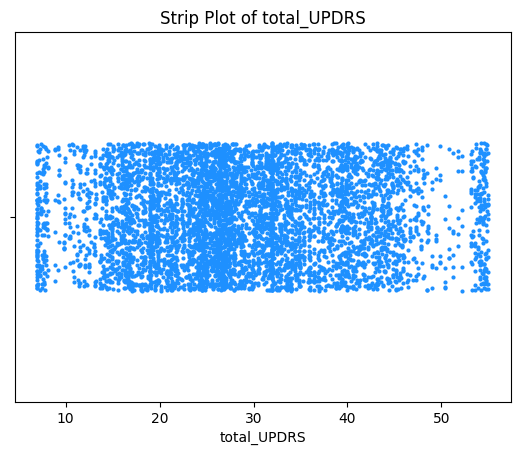

In [75]:
print(y_target.describe())
print(y_target.unique())
print(y_target.head(10))
sns.stripplot(x=y_target, color='dodgerblue', size=3, jitter=0.2)
plt.title("Strip Plot of total_UPDRS")
plt.xlabel("total_UPDRS")
plt.show()

### 4-way split

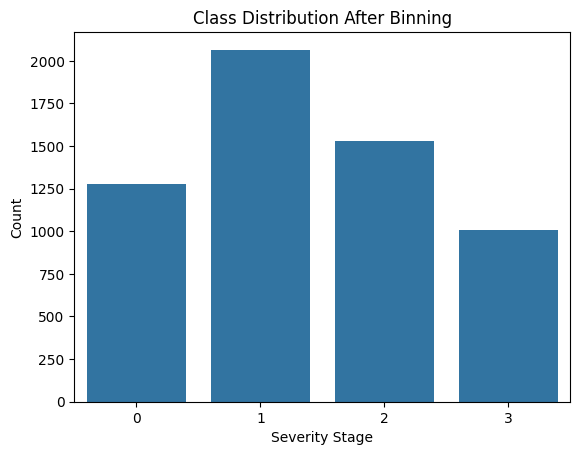

In [37]:
#4-way Split
bins = [0, 20, 30, 40, float('inf')]
labels = [0, 1, 2, 3]  
y_classify = pd.cut(y_target, bins=bins, labels=labels).astype(int)

### this is just a repeat of making traing/val of X and y
X_train, X_temp, y_train, y_temp = train_test_split(X_filtered, y_classify, test_size=0.5, stratify=y_classify, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
#making categorical y
y_train_cat = to_categorical(y_train, num_classes=4)
y_val_cat = to_categorical(y_val, num_classes=4)
###

sns.countplot(x=y_classify)
plt.title("Class Distribution After Binning")
plt.xlabel("Severity Stage")
plt.ylabel("Count")
plt.show()

Final Validation Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.63      0.65       319
           1       0.56      0.67      0.61       517
           2       0.56      0.52      0.54       382
           3       0.59      0.47      0.53       251

    accuracy                           0.59      1469
   macro avg       0.60      0.57      0.58      1469
weighted avg       0.59      0.59      0.59      1469



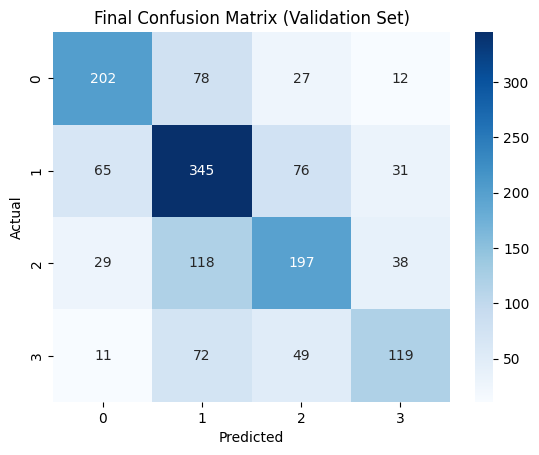

In [12]:
# Build the final model with best grid parameters
final_model = RandomForestClassifier(
    n_estimators=700,
    max_depth=20,
    max_features='log2',
    min_samples_leaf=2,
    min_samples_split=2,
    class_weight='balanced',
    random_state=42
)

final_model.fit(X_train, y_train)

y_val_pred = final_model.predict(X_val)

print("Final Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

cm = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Final Confusion Matrix (Validation Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Epoch 1/200
92/92 [==============================] - 2s 8ms/step - loss: 1.4784 - accuracy: 0.3214 - val_loss: 1.3217 - val_accuracy: 0.4261 - lr: 0.0010
Epoch 2/200
92/92 [==============================] - 0s 4ms/step - loss: 1.2876 - accuracy: 0.4195 - val_loss: 1.2619 - val_accuracy: 0.4472 - lr: 0.0010
Epoch 3/200
92/92 [==============================] - 0s 4ms/step - loss: 1.2407 - accuracy: 0.4474 - val_loss: 1.2012 - val_accuracy: 0.4997 - lr: 0.0010
Epoch 4/200
92/92 [==============================] - 0s 4ms/step - loss: 1.1843 - accuracy: 0.4678 - val_loss: 1.1312 - val_accuracy: 0.4997 - lr: 0.0010
Epoch 5/200
92/92 [==============================] - 0s 4ms/step - loss: 1.1647 - accuracy: 0.4668 - val_loss: 1.0805 - val_accuracy: 0.5269 - lr: 0.0010
Epoch 6/200
92/92 [==============================] - 0s 4ms/step - loss: 1.1554 - accuracy: 0.4866 - val_loss: 1.0618 - val_accuracy: 0.5453 - lr: 0.0010
Epoch 7/200
92/92 [==============================] - 0s 4ms/step - loss: 1.1

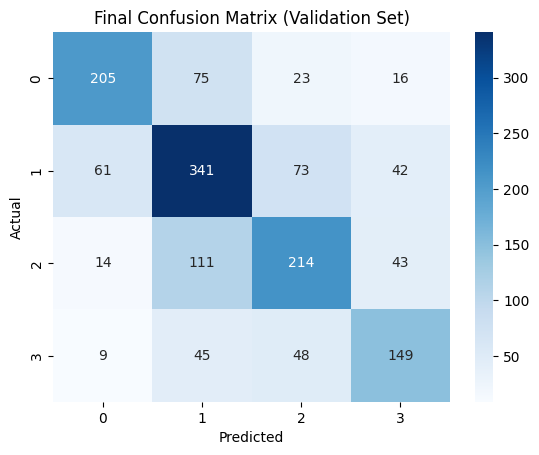

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Build model
model = Sequential([
    Dense(256, input_shape=(X_train_scaled.shape[1],)),
    LeakyReLU(alpha=0.01),
    BatchNormalization(),
    Dropout(0.4),

    Dense(128),
    LeakyReLU(alpha=0.01),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64),
    LeakyReLU(alpha=0.01),
    BatchNormalization(),
    Dropout(0.2),

    Dense(32),
    LeakyReLU(alpha=0.01),
    
    Dense(4, activation='softmax')  
])

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, verbose=1)

# Train
history = model.fit(
    X_train_scaled, y_train_cat,
    validation_data=(X_val_scaled, y_val_cat),
    epochs=200,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

y_val_pred = model.predict(X_val_scaled)
y_val_pred_classes = tf.argmax(y_val_pred, axis=1)

print("Keras MLP Classification Report:")
print(classification_report(y_val, y_val_pred_classes))

cm = confusion_matrix(y_val, y_val_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Final Confusion Matrix (Validation Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [39]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# Predict softmax probabilities from Keras model
y_val_probs = model.predict(X_val_scaled)

# Binarize the true labels to one-hot (if not already)
y_val_bin = label_binarize(y_val, classes=[0, 1, 2, 3])  # shape: (n_samples, 4)

# ROC AUC Scores
auc_macro = roc_auc_score(y_val_bin, y_val_probs, average='macro', multi_class='ovr')
auc_weighted = roc_auc_score(y_val_bin, y_val_probs, average='weighted', multi_class='ovr')
auc_per_class = [roc_auc_score(y_val_bin[:, i], y_val_probs[:, i]) for i in range(4)]

print(f"ROC AUC (macro): {auc_macro:.4f}")
print(f"ROC AUC (weighted): {auc_weighted:.4f}")
for i, auc in enumerate(auc_per_class):
    print(f"Class {i} AUC: {auc:.4f}")


46/46 [==============================] - 0s 1ms/step
ROC AUC (macro): 0.8579
ROC AUC (weighted): 0.8489
Class 0 AUC: 0.9055
Class 1 AUC: 0.8066
Class 2 AUC: 0.8371
Class 3 AUC: 0.8823


### 3-way split

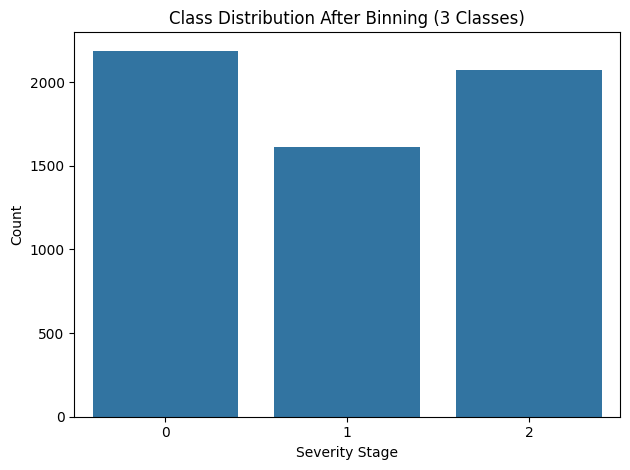

In [45]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
import seaborn as sns
import matplotlib.pyplot as plt

# --- Binning: 3-class severity levels based on total_UPDRS ---
bins = [0, 25, 32, float('inf')]
labels = [0, 1, 2]
y_classify = pd.cut(y_target, bins=bins, labels=labels).astype(int)

# --- Train/Val/Test split (with stratification on class labels) ---
X_train, X_temp, y_train, y_temp = train_test_split(
    X_filtered, y_classify, test_size=0.5, stratify=y_classify, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# --- Scale input features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# --- One-hot encode class labels for classification ---
num_classes = len(np.unique(y_classify))
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_val_cat = to_categorical(y_val, num_classes=num_classes)

# --- Plot class distribution ---
sns.countplot(x=y_classify)
plt.title("Class Distribution After Binning (3 Classes)")
plt.xlabel("Severity Stage")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

Epoch 1/300
184/184 [==============================] - 3s 6ms/step - loss: 1.1795 - accuracy: 0.4205 - val_loss: 1.0281 - val_accuracy: 0.4826 - lr: 0.0010
Epoch 2/300
184/184 [==============================] - 1s 4ms/step - loss: 1.0381 - accuracy: 0.4743 - val_loss: 0.9809 - val_accuracy: 0.5099 - lr: 0.0010
Epoch 3/300
184/184 [==============================] - 1s 4ms/step - loss: 1.0018 - accuracy: 0.4923 - val_loss: 0.9358 - val_accuracy: 0.5405 - lr: 0.0010
Epoch 4/300
184/184 [==============================] - 1s 4ms/step - loss: 0.9691 - accuracy: 0.5182 - val_loss: 0.9216 - val_accuracy: 0.5650 - lr: 0.0010
Epoch 5/300
184/184 [==============================] - 1s 4ms/step - loss: 0.9405 - accuracy: 0.5475 - val_loss: 0.8973 - val_accuracy: 0.5664 - lr: 0.0010
Epoch 6/300
184/184 [==============================] - 1s 4ms/step - loss: 0.9262 - accuracy: 0.5495 - val_loss: 0.8780 - val_accuracy: 0.5800 - lr: 0.0010
Epoch 7/300
184/184 [==============================] - 1s 4ms/st

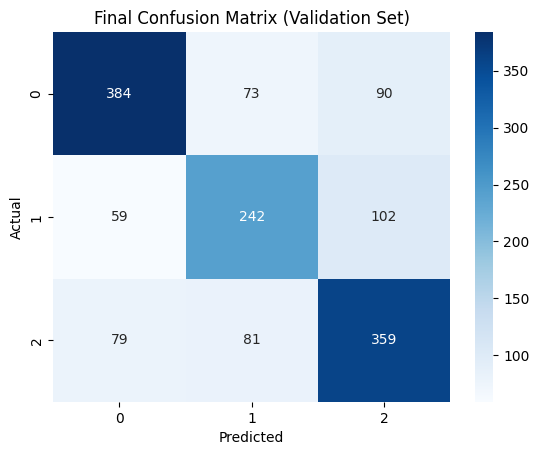

In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Build model
model = Sequential([
    Dense(256, input_shape=(X_train_scaled.shape[1],)),
    LeakyReLU(alpha=0.01),
    BatchNormalization(),
    Dropout(0.4),

    Dense(128),
    LeakyReLU(alpha=0.01),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64),
    LeakyReLU(alpha=0.01),
    BatchNormalization(),
    Dropout(0.2),

    Dense(32),
    LeakyReLU(alpha=0.01),
    
    Dense(3, activation='softmax')  
])

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.01),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, verbose=1)

# Train
history = model.fit(
    X_train_scaled, y_train_cat,
    validation_data=(X_val_scaled, y_val_cat),
    epochs=300,
    batch_size=16,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

y_val_pred = model.predict(X_val_scaled)
y_val_pred_classes = tf.argmax(y_val_pred, axis=1)

print("Keras MLP Classification Report:")
print(classification_report(y_val, y_val_pred_classes))

cm = confusion_matrix(y_val, y_val_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Final Confusion Matrix (Validation Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [61]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# Predict class probabilities (softmax output)
y_val_probs = model.predict(X_val_scaled)

# Binarize the true labels (in case it's not already)
y_val_bin = label_binarize(y_val, classes=[0, 1, 2])  # shape: (n_samples, 3)

# Compute ROC AUC (macro, weighted, per-class)
auc_macro = roc_auc_score(y_val_bin, y_val_probs, average='macro', multi_class='ovr')
auc_weighted = roc_auc_score(y_val_bin, y_val_probs, average='weighted', multi_class='ovr')
auc_per_class = [roc_auc_score(y_val_bin[:, i], y_val_probs[:, i]) for i in range(3)]

print(f"ROC AUC (macro): {auc_macro:.4f}")
print(f"ROC AUC (weighted): {auc_weighted:.4f}")
for i, auc in enumerate(auc_per_class):
    print(f"Class {i} AUC: {auc:.4f}")

46/46 [==============================] - 0s 2ms/step
ROC AUC (macro): 0.8478
ROC AUC (weighted): 0.8486
Class 0 AUC: 0.8559
Class 1 AUC: 0.8405
Class 2 AUC: 0.8470


### Categorical using motor - 3-way since its range is small

In [10]:
#y_target = y["total_UPDRS"]
y_target = y["motor_UPDRS"]


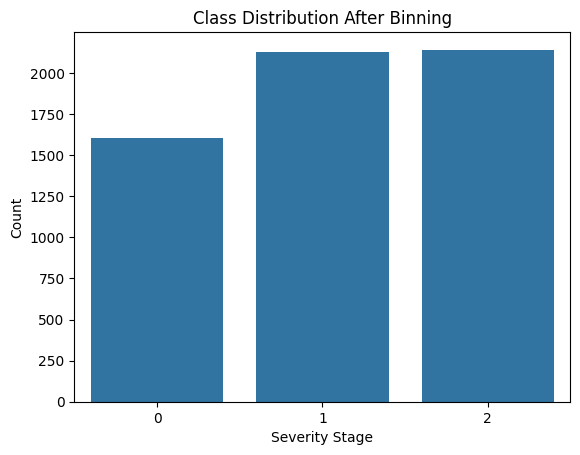

In [13]:
bins = [0, 15, 25, float('inf')]
labels = [0, 1, 2]  
y_classify = pd.cut(y_target, bins=bins, labels=labels).astype(int)

### this is just a repeat of making traing/val of X and y
X_train, X_temp, y_train, y_temp = train_test_split(X_filtered, y_classify, test_size=0.5, stratify=y_classify, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
#making categorical y
y_train_cat = to_categorical(y_train, num_classes=3)
y_val_cat = to_categorical(y_val, num_classes=3)
###
sns.countplot(x=y_classify)
plt.title("Class Distribution After Binning")
plt.xlabel("Severity Stage")
plt.ylabel("Count")
plt.show()

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

# Build model
model = Sequential([
    Dense(256, input_shape=(X_train_scaled.shape[1],)),
    LeakyReLU(alpha=0.01),
    BatchNormalization(),
    Dropout(0.4),

    Dense(128),
    LeakyReLU(alpha=0.01),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64),
    LeakyReLU(alpha=0.01),
    BatchNormalization(),
    Dropout(0.2),

    Dense(32),
    LeakyReLU(alpha=0.01),
    
    Dense(4, activation='softmax')  
])

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, verbose=1)

# Train
history = model.fit(
    X_train_scaled, y_train_cat,
    validation_data=(X_val_scaled, y_val_cat),
    epochs=200,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

y_val_pred = model.predict(X_val_scaled)
y_val_pred_classes = tf.argmax(y_val_pred, axis=1)

print("Keras MLP Classification Report:")
print(classification_report(y_val, y_val_pred_classes))


Epoch 1/200


ValueError: in user code:

    File "/root/venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/root/venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/root/venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/root/venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/root/venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "/root/venv/lib/python3.10/site-packages/keras/src/engine/compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/root/venv/lib/python3.10/site-packages/keras/src/losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "/root/venv/lib/python3.10/site-packages/keras/src/losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/root/venv/lib/python3.10/site-packages/keras/src/losses.py", line 2221, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/root/venv/lib/python3.10/site-packages/keras/src/backend.py", line 5573, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 3) and (None, 4) are incompatible


In [1]:
# Save the model as HDF5 (.h5)
model.save('mlp_model.h5')

# For download link (works in Deepnote and Jupyter)
from IPython.display import FileLink

# Create clickable download link
FileLink('mlp_model.h5')


NameError: name 'model' is not defined